In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torchvision
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from PIL import Image
import random


## $\textcolor{green}{\text{MLP on Large Data set with PyTorch}}$

Let's create a NN on a bigger data set. We will use MNIST Digit set. This time we will upload a set containing 60000 digits of a higher quality than before. We will use PyTorch to do so. We will also preprocess our data. We will use `transforms`, which is a way to create Pipelines with PyTorch. I want to convert every image into Tensor and then Normalize the values so that they are smaller. We can apply these transforms directly the moment we upload our data sets.



In [89]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),    # mean and std
                              ])

In [90]:
trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [91]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [92]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Let's look at the single batch and single image.

In [93]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

As you can see, a single batch is a 4-dim array:
1. 64 is the amount of images in the single batch
2. 1 is a color channel. Since our images are greyscale we have only one chanel. This dim is useless to us. Technically, we could have applied transform to get rid of it. Note, if our image is a color image, this will usually have 3 values (RGB).
3. 28, 28 is the size of a single image. It is 28 by 28 pixels.

Let's see what a the first image looks like. (`squeeze` gets rid of singular dimension)

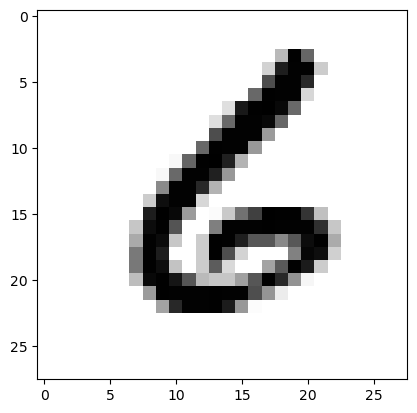

In [94]:
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r')
plt.show()

And here are few more examples:

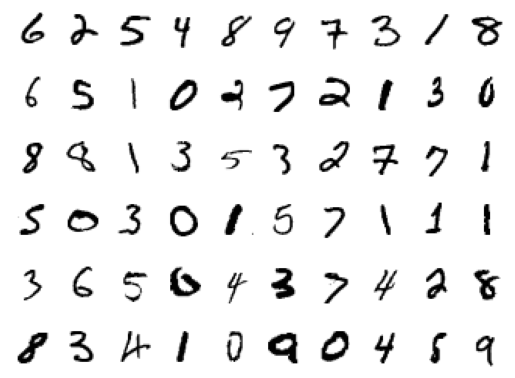

In [95]:
figure = plt.figure()
num_of_images = 60
for idx in range(1, num_of_images + 1):
    plt.subplot(6, 10, idx)
    plt.axis('off')
    plt.imshow(images[idx].numpy().squeeze(), cmap='gray_r')

Before we start creating our models, I want to add a small function to calculate accuracy and loss:

In [96]:
def get_acc_loss(model, loader):
    correct=0
    total=0
    for images, labels in loader:
        output=model(images)
        pred = output.data.max(1, keepdim=True)[1]
        total+=labels.shape[0]
        correct += pred.eq(labels.data.view_as(pred)).sum()
        loss=loss_func(output, labels)
    acc=100.*correct/total
    return acc, loss

Let's create our NN. This time I will use 3 hidden layers. I will also add `nn.Sequential` to avoid retyping our functions in the forward method. Lastly, I will use `flatten` to convert 28 by 28 array into a single dimension vector of size 28*28 = 784

In [97]:
input_size = 784     # 28*28
hidden_sizes = [256, 64, 32] #three hidden layers
output_size = 10


class DigitMLP(nn.Module):

    def __init__(self):
        super(DigitMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



In [98]:
model = DigitMLP()
print(model)

n_epochs=3
lr=0.01

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum =0.9)


DigitMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [99]:
train_loss = []
test_loss = []

train_acc=[]
test_acc=[]

In [100]:
n=len(trainloader)

for epoch in range(n_epochs):
    model.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()

        if (idx+1)%100==0:
            print(f'Epoch {epoch+1}/{n_epochs}, step {idx+1}/{n}, Loss={loss.item():.3}')

    model.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model, testloader)
        test_acc.append(acc)
        test_loss.append(loss)
        print(f'\nTest Accuracy = {acc}, Test Loss = {loss} \n')

        acc, loss = get_acc_loss(model, trainloader)
        train_acc.append(acc)
        train_loss.append(loss)

Epoch 1/3, step 100/938, Loss=1.05
Epoch 1/3, step 200/938, Loss=0.653
Epoch 1/3, step 300/938, Loss=0.575
Epoch 1/3, step 400/938, Loss=0.224
Epoch 1/3, step 500/938, Loss=0.276
Epoch 1/3, step 600/938, Loss=0.312
Epoch 1/3, step 700/938, Loss=0.413
Epoch 1/3, step 800/938, Loss=0.571
Epoch 1/3, step 900/938, Loss=0.441

Test Accuracy = 93.11000061035156, Test Loss = 0.059080369770526886 

Epoch 2/3, step 100/938, Loss=0.181
Epoch 2/3, step 200/938, Loss=0.289
Epoch 2/3, step 300/938, Loss=0.219
Epoch 2/3, step 400/938, Loss=0.0541
Epoch 2/3, step 500/938, Loss=0.193
Epoch 2/3, step 600/938, Loss=0.132
Epoch 2/3, step 700/938, Loss=0.269
Epoch 2/3, step 800/938, Loss=0.091
Epoch 2/3, step 900/938, Loss=0.108

Test Accuracy = 94.87999725341797, Test Loss = 0.13149394094944 

Epoch 3/3, step 100/938, Loss=0.155
Epoch 3/3, step 200/938, Loss=0.13
Epoch 3/3, step 300/938, Loss=0.18
Epoch 3/3, step 400/938, Loss=0.026
Epoch 3/3, step 500/938, Loss=0.18
Epoch 3/3, step 600/938, Loss=0.341
E

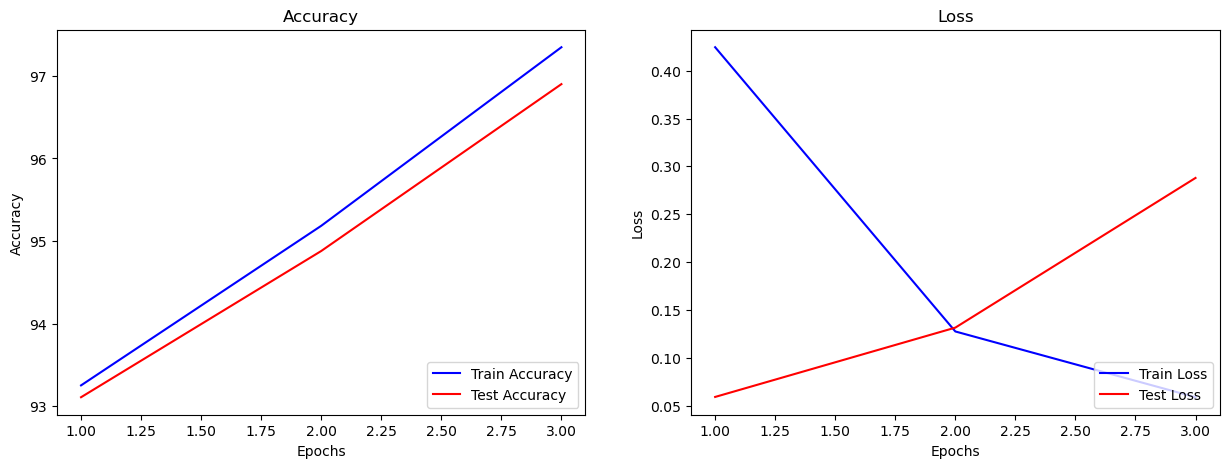

In [101]:
fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,n_epochs+1, 1), train_acc, color='blue')
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc, color='red')
ax[0].legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy')

ax[1].plot(np.arange(1,n_epochs+1, 1), train_loss, color='blue')
ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss, color='red')
ax[1].legend(['Train Loss', 'Test Loss'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')

plt.show()

In [102]:
predictions = []
y_true = []
model.eval()
with torch.inference_mode():
# iterate over test data
    for inputs, labels in testloader:
    
            output = model(inputs) # Feed Network
    
            output = (torch.max(torch.exp(output), 1)[1])
            predictions.extend(output) # Save Prediction
    
            labels = labels.data.numpy()
            y_true.extend(labels) # Save Truth


print('Confusion Matrix = \n',confusion_matrix(y_true, predictions))

Confusion Matrix = 
 [[ 972    0    1    1    1    1    1    1    1    1]
 [   0 1119    3    3    0    2    2    2    4    0]
 [   9    2 1005    1    4    0    1    6    3    1]
 [   1    0    6  978    0   13    0    6    4    2]
 [   1    0    6    1  935    1    1    3    2   32]
 [   7    0    0    7    2  860    7    0    6    3]
 [  12    3    0    1    6    5  927    0    4    0]
 [   4    5   12    4    1    1    0  986    2   13]
 [   5    0    5    5    3    1    6    4  944    1]
 [   5    4    1    9    9    6    0    6    5  964]]


---
## $\textcolor{green}{\text{How do we choose amount of layers and amount of nodes in each layer?}}$
For input and output layer, this is easy, there is only one choice. However for hidden layers, this is not an easy question and highly depends on many factors. Clearly, the more layers and more nodes we have the more computationally expensive model will be. Another thing to keep in mind is that the more layers we have, more likely we will get Vanishing Gradient Problem. So, for very deep networks, we should apply more specialized algorithms. However, for most problems we don't need very deep networks:

1. If your data is linearly separable, then you actually dont need any hidden layers. You dont really need NN at all here.
2. A single hidden layer can solve most problems.
3. Problems that require two hidden layers are more rare, but we can create almost any desision boundary with it.
4. Generally, the more features you have, the more layers you will probably want. Hidden layers in deep NN are generally more complex than just a linear layers we discussed so far. Problems that often use deep NN:
   
       a. Image or video recognision problems will use deeper NN (CNN);
   
       b. Language processing (translation, text generation, etc) will use deep NN (RNN, Transformers)
   
       c. Time series forecasting often use deep NN (LSTM)
   
       d. Speech Recognition use deep CNN and/or RNN.
   
5. Adding more layers may lead to overfit, so more is not always better.

How about number of nodes in each hidden layer? Again there is no single answers to this, but here are common suggestions (keep in mind that these are not hard rules and there are many exceptions):

1. Number of nodes in the hidden layer should be between number of nodes in the input layer and the output layer.
2. Number of nodes in the hidden layer should be 2/3 of the sum of number of nodes in the input layer and the output layer.
3. Number of nodes in the hidden layer should be less than double the number of nodes in the input layer.
   
Other things that we can manipulate to improve our NN model:

1. Learning rate
2. Momentum (when we do SGD and you gradinet is small, the convergence slows down dramatically. Momentum let's you use previous gradients. It speeds up the convergence.
3. We can apply early stopping to avoid overfiting and improve performance
4. We can use other optimizers besides SGD ( such as Adam, Adagrad, AdaDelta, Nadam, Adamax, etc)

We will talk about momentum and optimizers in the future.

---
#### $\textcolor{red}{\text{Continuation of the Example}}$

In [103]:
torch.save(model.state_dict(), '.\DigitMLPExample.pth')

Let's draw a picture and see if our model can guess the digit (The digit should be white on black background, and saved as Digit.png).

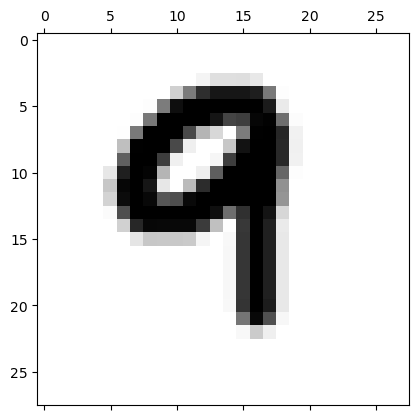

In [104]:
image = Image.open('Digit.png')
img = image.convert('L')    # converts it to greyscale
img = img.resize((28,28))
img_plot = np.asarray(img)

plt.matshow(img_plot, cmap = 'gray_r')
plt.show()

In [105]:
imgtensor = transform(img)
model.eval()
with torch.inference_mode():

    output = model(imgtensor)
    guess=(torch.max(torch.exp(output), 1)[1])[0]
    perc=torch.max(torch.exp(output)/torch.exp(output).sum())*100
    print(f'This is {guess}, and I am {perc:.1f}% confident about this')

This is 9, and I am 62.2% confident about this


Overall our guesses were ok, but for image recognition, we should be using a different type of Neural Network called Convolutional Neural Network (CNN), which we will look at next time.

---
## $\textcolor{green}{\text{Dealing with overfit}}$
Neural networks are notorious at overfitting since they add a lot of complexity. This is even more prominent for small data sets. There are a few ways to combat overfitting:

1. For non-image data normalization is helpful
2. Data augmentation: adding small rotation, shifts and noise to images
3. Adding regularizatrion. Recall that weight decay in SGD is L2-regularization
4. Dropout: we can randomly drop a few neurons in each training iteration to add a bit of weight independence.
5. Early stopping. stop training when validation accuracy no longer improves.
6. Pooling: dimension reduction on images.

Let's take a smaller subset of digits and increase amount of epochs. We will also add extra nodes to a hidden layer to force overfit. Then we will create a new model with few features to combat overfit. I will also use validation and test set.


In [106]:
# This function will split train set into train and validation and then create loaders for all three sets

def get_sets(train_data, test_data):
    valid_size = 0.2

    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=10,
                                               sampler=train_sampler,
                                               num_workers=0)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=10,
                                               sampler=valid_sampler,
                                               num_workers=0)

    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=100,
                                              num_workers=0)

    return train_loader, test_loader, valid_loader

In [107]:
trainset_list_full= list(trainset)
testset_list_full= list(testset)


In [108]:
trainset_list=random_values = random.sample(trainset_list_full, 100)
testset_list=random_values = random.sample(testset_list_full, 2000)

trainloader, testloader, validloader=get_sets(trainset_list, testset_list)

In [109]:
input_size = 784     # 28*28
hidden_sizes = [500, 500, 500]
output_size = 10


class DigitMLP(nn.Module):

    def __init__(self):
        super(DigitMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



In [110]:
model1 = DigitMLP()
n_epochs=100
lr=0.01

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=lr, momentum =0.9)

In [111]:
train_loss = []
val_loss = []
train_acc=[]
val_acc=[]

In [112]:
for epoch in range(n_epochs):
    model1.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model1(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()


    model1.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model1, validloader)
        val_acc.append(acc)
        val_loss.append(loss)

        acc, loss = get_acc_loss(model1, trainloader)
        train_acc.append(acc)
        train_loss.append(loss)

    if epoch%10==9:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss={loss.item():.3}')


Epoch 10/100, Loss=0.654
Epoch 20/100, Loss=0.0344
Epoch 30/100, Loss=0.000774
Epoch 40/100, Loss=0.000493
Epoch 50/100, Loss=0.000334
Epoch 60/100, Loss=0.000284
Epoch 70/100, Loss=0.000406
Epoch 80/100, Loss=0.000189
Epoch 90/100, Loss=0.000245
Epoch 100/100, Loss=0.00017


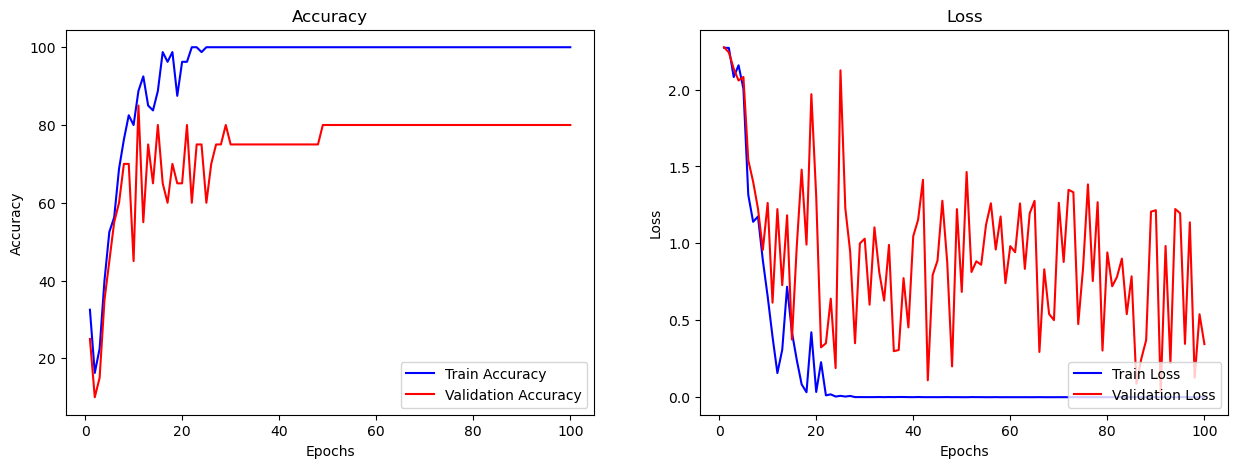

In [113]:
fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,n_epochs+1, 1), train_acc, color='blue')
ax[0].plot(np.arange(1,n_epochs+1, 1), val_acc, color='red')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy')

ax[1].plot(np.arange(1,n_epochs+1, 1), train_loss, color='blue')
ax[1].plot(np.arange(1,n_epochs+1, 1), val_loss, color='red')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')

plt.show()

In [114]:
model1.eval()
with torch.inference_mode():
    acc, _ = get_acc_loss(model1, testloader)
    print(f'Accuracy on test set: {acc}')

Accuracy on test set: 67.75


As you can see we our model does perfectly on train set, but badly on test set. We are overfitting. Let add few things to our model. First thing we will add a bit of rotation to our images. Normally you can add those to your initial transform, but this time I will add it separately. Here is an example:

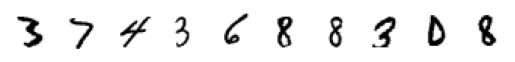

In [115]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 10
for index in range(0, num_of_images):
    plt.subplot(1, 10, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

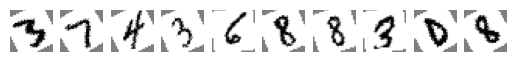

In [116]:
images=[transforms.RandomRotation(degrees=(0, 35))(im) for im in images]
figure = plt.figure()
num_of_images = 10
for index in range(0, num_of_images):
    plt.subplot(1, 10, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Next, we will use L2-Normalization by setting weight decay to 0.01. Finally, we will add a dropout layers to remove certain neurons. Note that dropout layer is not being used during testing. Your model will know if you are testing or training when you use `model.eval()` and `model.train()`.

In [117]:
input_size = 784     # 28*28
hidden_sizes = [500, 500, 500]
output_size = 10


class DigitMLP2(nn.Module):

    def __init__(self):
        super(DigitMLP2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[2], output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [118]:
model2 = DigitMLP2()
n_epochs=100
lr=0.01

In [119]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=lr, momentum =0.8, weight_decay=0.01)

I will also create Early Stopping that will test validation set's loss. If it stops improving, we will stop training.

In [120]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = np.inf  # Assuming we are minimizing the validation loss
        self.early_stop = False

    def __call__(self, val_loss):
        score = val_loss

        if score < self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            if self.verbose:
                print(f'Validation loss improved: {self.best_score:.6f}')
        else:
            self.counter += 1
            if self.verbose:
                print(f'Validation loss did not improve: {score:.6f}. Counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

In [121]:
early_stopping = EarlyStopping(patience=10, verbose=True)

train_loss = []
val_loss = []
train_acc=[]
val_acc=[]



for epoch in range(n_epochs):
    model2.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        images=transforms.RandomRotation((-25,25))(images)
        output = model2(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model2.eval()
    with torch.inference_mode():

        v_acc, v_loss = get_acc_loss(model2, validloader)
        val_acc.append(v_acc)
        val_loss.append(v_loss)

        t_acc, t_loss = get_acc_loss(model2, trainloader)
        train_acc.append(t_acc)
        train_loss.append(t_loss)


    print(f'Epoch {epoch+1}/{n_epochs}, Validation Loss: {v_loss:.6f}')

    # Check early stopping
    early_stopping(v_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        total_n_epochs=epoch+1
        break
    total_n_epochs=epoch+1

Epoch 1/100, Validation Loss: 2.281187
Validation loss improved: 2.281187
Epoch 2/100, Validation Loss: 2.296494
Validation loss did not improve: 2.296494. Counter: 1/10
Epoch 3/100, Validation Loss: 2.226760
Validation loss improved: 2.226760
Epoch 4/100, Validation Loss: 2.187263
Validation loss improved: 2.187263
Epoch 5/100, Validation Loss: 2.337414
Validation loss did not improve: 2.337414. Counter: 1/10
Epoch 6/100, Validation Loss: 2.235930
Validation loss did not improve: 2.235930. Counter: 2/10
Epoch 7/100, Validation Loss: 2.212499
Validation loss did not improve: 2.212499. Counter: 3/10
Epoch 8/100, Validation Loss: 2.135158
Validation loss improved: 2.135158
Epoch 9/100, Validation Loss: 2.078521
Validation loss improved: 2.078521
Epoch 10/100, Validation Loss: 1.934287
Validation loss improved: 1.934287
Epoch 11/100, Validation Loss: 1.405990
Validation loss improved: 1.405990
Epoch 12/100, Validation Loss: 1.614663
Validation loss did not improve: 1.614663. Counter: 1/10

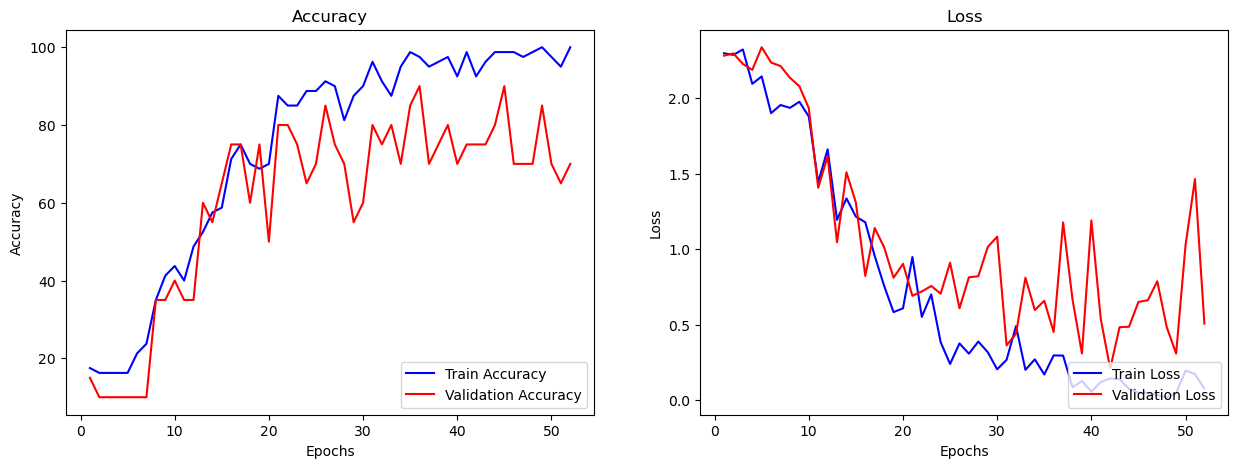

In [122]:
fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,total_n_epochs+1, 1), train_acc, color='blue')
ax[0].plot(np.arange(1,total_n_epochs+1, 1), val_acc, color='red')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy')

ax[1].plot(np.arange(1,total_n_epochs+1, 1), train_loss, color='blue')
ax[1].plot(np.arange(1,total_n_epochs+1, 1), val_loss, color='red')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')

plt.show()

In [123]:
model2.eval()
with torch.inference_mode():
    acc, _ = get_acc_loss(model2, testloader)
    print(f'Accuracy on test set: {acc}')

Accuracy on test set: 73.4000015258789


In [124]:
imgtensor = transform(img)
model2.eval()
with torch.inference_mode():

    output = model2(imgtensor)
    guess=(torch.max(torch.exp(output), 1)[1])[0]
    perc=torch.max(torch.exp(output)/torch.exp(output).sum())*100
    print(f'This is {guess}, and I am {perc:.1f}% confident about this')

This is 9, and I am 63.9% confident about this


In [125]:
output

tensor([[-2.8995e+00, -3.7736e+00,  3.4487e-01,  4.6244e+00, -1.1017e+00,
         -1.1140e+00, -5.0042e+00,  3.3370e+00, -3.6397e-03,  5.4632e+00]])